GPflow 2.0 preview
--

Early version of GPflow 2.0 based on eager mode tensorflow 1.12.

In [2]:
from typing import Optional

from matplotlib import pyplot as plt
%matplotlib inline

import json
import logging
import sys
import scipy
import csv
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import gpflow

from scipy.cluster.vq import kmeans
from classification import load_banana_data, plot_predictions
from gpflow.test_util import notebook_niter, notebook_list

logging.disable(logging.WARN)

tfe = tf.contrib.eager

### 1. Numpy, GPflow Variables and Bijectors:

In [17]:
v = tfe.Variable(10.)
print(f"Standard TensorFlow variable: {v}")

Standard TensorFlow variable: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=10.0>


In [26]:
v = gpflow.Parameter(10.)
print(f"GPflow parameter: {v}")

v <<= 11.0
print(v)

GPflow parameter: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=10.0>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=11.0>


In [19]:
assert isinstance(v, tfe.Variable)

In [20]:
transform = tfp.bijectors.Exp()
constrained_pythonic_value = 10.
v = gpflow.Parameter(constrained_pythonic_value, transform=transform)
constrained_tensorflow_value = v()
print(f"Unconstained value: {v}")
print(f"Constrained value: {constrained_tensorflow_value}")

Unconstained value: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.302585092994046>
Constrained value: 10.000000000000002


### 2. Models, training and cetera

Load the data and set parameters for the model:

In [11]:
x_train, y_train = train_data = load_banana_data()

Let's create callbacks for optimizers:

In [21]:
# Setup the experiment and plotting.
class Callback:
    def __init__(self, callback, offset: Optional[int] = 1):
        assert callback is not None
        self.iteration = 0
        self.offset = offset
        self.callback = callback
        
    def __call__(self, loss, variables, grads):
        if self.offset is not None and self.iteration % self.offset == 0:
            self.callback(self.iteration, loss, variables, grads)
        self.iteration += 1
            

def step_cb(iteration, loss, parameters, grads):
    print(f"Iteration = {iteration}, Loss value = {loss}, Loss type = {type(loss)}")

Run training process:

In [27]:
inducing_points = [4, 8, 16]
models = []

for index, num_inducing_points in enumerate(inducing_points):
    print(f"Training for model={index} and inducing points={num_inducing_points}")
    
    # K-means for selecting Z
    Z = kmeans(x_train, num_inducing_points)[0]

    kernel = gpflow.kernels.RBF()
    likelihood = gpflow.likelihoods.Bernoulli()
    model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, feature=Z)
    
    x = tf.convert_to_tensor(x_train)
    y = tf.convert_to_tensor(y_train)
    
    def loss_fn():
        return model.elbo(x, y)

    # Initially fix the hyperparameters.
    model.feature.trainable = False
    variables = model.trainable_variables
    
    scipy = gpflow.training.ScipyOptimizer()
    scipy.minimize(loss_fn, variables, options=dict(maxiter=20))

    # Unfix the hyperparameters.
    model.feature.trainable = True
    variables = model.trainable_variables
    callback = Callback(step_cb, offset=20)
    scipy.minimize(loss_fn, variables, options=dict(maxiter=1000), step_callback=callback)
    models.append(model)

Training for model=0 and inducing points=4
Iteration = 0, Loss value = 270.5378510664821, Loss type = <class 'tensorflow.python.framework.ops.EagerTensor'>
Iteration = 20, Loss value = 259.85397402929306, Loss type = <class 'tensorflow.python.framework.ops.EagerTensor'>
Iteration = 40, Loss value = 232.71367594472792, Loss type = <class 'tensorflow.python.framework.ops.EagerTensor'>
Iteration = 60, Loss value = 224.4265617311619, Loss type = <class 'tensorflow.python.framework.ops.EagerTensor'>
Iteration = 80, Loss value = 218.98509206683946, Loss type = <class 'tensorflow.python.framework.ops.EagerTensor'>
Iteration = 100, Loss value = 218.3578077605088, Loss type = <class 'tensorflow.python.framework.ops.EagerTensor'>
Iteration = 120, Loss value = 218.22124684069723, Loss type = <class 'tensorflow.python.framework.ops.EagerTensor'>
Training for model=1 and inducing points=8
Iteration = 0, Loss value = 158.54588135964326, Loss type = <class 'tensorflow.python.framework.ops.EagerTensor

KeyboardInterrupt: 

Plot classification boundaries:

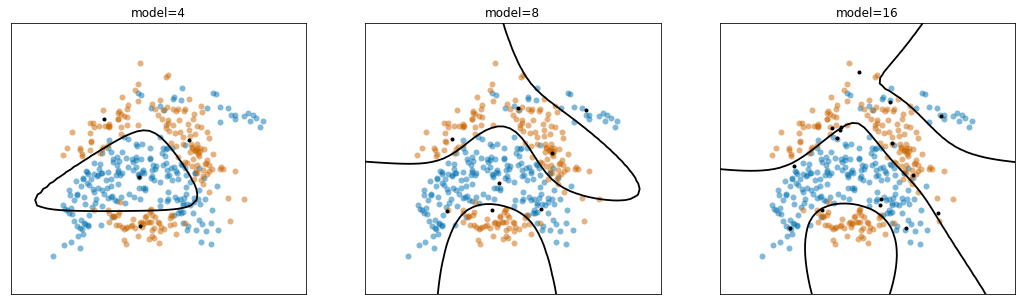

In [56]:
fig, axes = plt.subplots(1, len(models), figsize=(18, 5), sharex=True, sharey=True)

for i, model in enumerate(models):
    plot_predictions(model, train_data, axes[i])
    axes[i].set_yticks([])
    axes[i].set_xticks([])

#### Traning with Adam optimizer:

Setup the model and dataset iterators:

In [13]:
num_inducing_points = 10

features = kmeans(x_train, num_inducing_points)[0]
kernel = gpflow.kernels.RBF()
likelihood = gpflow.likelihoods.Bernoulli()
model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, feature=features)


dataset = tf.data.Dataset()\
            .from_tensor_slices((x_train, y_train))\
            .shuffle(buffer_size=1024)\
            .repeat()\
            .batch(64)

dataset_iter = dataset.make_one_shot_iterator()

In [16]:
adam = tf.train.AdamOptimizer(0.001)
maxiter = 100

def optimize_step(step, x, y):
    with tf.GradientTape() as tape:
        elbo = model.elbo(x, y)
        variables = model.trainable_variables
        grads = tape.gradient(elbo, variables)
        grads_and_vars = zip(grads, variables)
        adam.apply_gradients(grads_and_vars)

optimize_step_opt = tf.function(optimize_step)
        
for step, (x, y) in enumerate(dataset_iter):
    if step > maxiter:
        break
    if step % 20 == 0:
        print(f"Adam iteration {step}")
    optimize_step_opt(step, x, y)

Adam iteration 0
Adam iteration 20
Adam iteration 40
Adam iteration 60
Adam iteration 80
Adam iteration 100
